# Проект e-commerce

In [152]:
import os
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [153]:
customers=pd.read_csv("C:/Users/Алексей/Lessons file/olist_customers_dataset.csv")
olist_orders=pd.read_csv('C:/Users/Алексей/Lessons file/olist_orders_dataset (1).csv')
order_items=pd.read_csv('C:/Users/Алексей/Lessons file/olist_order_items_dataset.csv')

### 1. Сколько у нас пользователей, которые совершили покупку только один раз

In [154]:
sales_df=customers.merge(olist_orders,how='inner',on='customer_id') # Обьеденим таблицу с уникальными идентификаторами пользователей и таблицу заказов.Объединять будем по order_id ,созданным заказам
sales_df.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05 00:00:00
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06 00:00:00
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13 00:00:00
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10 00:00:00
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15 00:00:00


In [155]:
real_sale=sales_df.query("order_status!=['unavailable','canceled']") 
# Для начала определим какие заказы будут считаться покупкой.Точно уберем unavailable —  недоступен,canceled —  отменён.
real_sale[real_sale.order_approved_at.isna()].order_status.value_counts()
# Далее проверим статус оплаты у оставшися заказов(посмотрим заказы без статуса оплаты)                   

delivered    14
created       5
Name: order_status, dtype: int64

In [156]:
real_sale=real_sale.query("order_status!='created'") 
#.Видим что 5 заказов были созданы ,но так и не были оплачены,значит их убираем.
# Еще 14 заказов со статусом доставленно ,но без оплаты.Будем считать что оплата по этим заказм после доставки.

In [157]:
real_sale_1count=real_sale.groupby('customer_unique_id',as_index=False).agg({'order_id':'count'})
# считаем количество заказов для каждого пользователя

In [158]:
count_1=real_sale_1count.query("order_id==1").agg({'customer_unique_id':'nunique'})
#оставляем только тех у кого 1 заказ
count_1

customer_unique_id    92099
dtype: int64

### 2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?



In [160]:
sales_df['order_purchase_timestamp'] = pd.to_datetime(sales_df['order_purchase_timestamp'])
new=sales_df.query("order_status!='delivered'")
# Будем счиать что заказ считается не доставленным,если имеет любой статус кроме "доставлен пользователю".
#Переведм колонку "order_purchase_timestamp" к типу даты,и отфильтруем таблицу ,убрав заказы со статусом 'доставлен пользователю'

In [161]:
new['order_purchase_timestamp'] = new['order_purchase_timestamp'].dt.to_period('M')
#Чтобы посчитать в среднем по месяцу нам нужно привести колонку "order_purchase_timestamp" к виду год/месяц.

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [162]:
count_reason=new.groupby(['order_purchase_timestamp','order_status'],as_index=False).agg({'order_id':'count'})
count_reason #не доставленно по разным причинам по месяцам

,order_purchase_timestamp,order_status,order_id
0,2016-09,canceled,2
1,2016-09,shipped,1
2,2016-10,canceled,24
3,2016-10,invoiced,18
4,2016-10,processing,2
...,...,...,...
108,2018-08,shipped,47
109,2018-08,unavailable,7
110,2018-09,canceled,15
111,2018-09,shipped,1


In [163]:
count_reason.groupby('order_status',as_index=False).agg({'order_id':'mean'}) # среднее в месяц по разным причинам

,order_status,order_id
0,approved,1.000000
1,canceled,26.041667
2,created,1.666667
3,invoiced,14.952381
4,processing,15.842105
5,shipped,48.130435
6,unavailable,29.000000


In [164]:
mean_reason=count_reason.groupby('order_purchase_timestamp').agg({'order_id':'sum'})
mean_reason.order_id.mean() # считаем среднее количество недоставленных по каждому месяцу и выводим среднее

123.45833333333333

### 3. По каждому товару определить, в какой день недели товар чаще всего покупается.




In [166]:
day_week=sales_df.merge(order_items,how='inner',on='order_id')
day_week=day_week.query("order_status!=['unavailable','canceled','created']")
day_week
#Объеденим таблицу заказов с таблицей товаров в заказе.Будем считать датой покупки,дату создания заказа(просто исходя из логики
# что покупка- это день когда человек что-то выбрал и заказал,оплата моджет пройти с опозданием ,или может быть в день доставки)
#Оставим только покупки(Будем считать,что покупкой является заказ не имеющий статус создан,недоступен,отменён)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05 00:00:00,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-05-22 15:22:12,124.99,21.88
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06 00:00:00,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-01-18 20:58:32,289.00,46.48
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13 00:00:00,1,bd07b66896d6f1494f5b86251848ced7,7c67e1448b00f6e969d365cea6b010ab,2018-06-05 16:19:10,139.94,17.79
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10 00:00:00,1,a5647c44af977b148e0a3a4751a09e2e,7c67e1448b00f6e969d365cea6b010ab,2018-03-27 16:31:16,149.94,23.36
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15 00:00:00,1,9391a573abe00141c56e38d84d7d5b3b,4a3ca9315b744ce9f8e9374361493884,2018-07-31 10:10:09,230.00,22.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112645,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8,3937,sao paulo,SP,6760e20addcf0121e9d58f2f1ff14298,delivered,2018-04-07 15:48:17,2018-04-07 16:08:45,2018-04-11 02:08:36,2018-04-13 20:06:37,2018-04-25 00:00:00,1,ccb4503d9d43d245d3b295d0544f988b,527801b552d0077ffd170872eb49683b,2018-04-12 16:08:45,74.90,13.88
112646,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,6764,taboao da serra,SP,9ec0c8947d973db4f4e8dcf1fbfa8f1b,delivered,2018-04-04 08:20:22,2018-04-04 08:35:12,2018-04-05 18:42:35,2018-04-11 18:54:45,2018-04-20 00:00:00,1,9ede6b0570a75a4b9de4f383329f99ee,3fd1e727ba94cfe122d165e176ce7967,2018-04-10 08:35:12,114.90,14.16
112647,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,60115,fortaleza,CE,fed4434add09a6f332ea398efd656a5c,delivered,2018-04-08 20:11:50,2018-04-08 20:30:03,2018-04-09 17:52:17,2018-05-09 19:03:15,2018-05-02 00:00:00,1,7a5d2e1e131a860ae7d18f6fffa9d689,d9e7e7778b32987280a6f2cb9a39c57d,2018-04-12 20:30:03,37.00,19.04
112648,56b18e2166679b8a959d72dd06da27f9,73c2643a0a458b49f58cea58833b192e,92120,canoas,RS,e31ec91cea1ecf97797787471f98a8c2,delivered,2017-11-03 21:08:33,2017-11-03 21:31:20,2017-11-06 18:24:41,2017-11-16 19:58:39,2017-12-05 00:00:00,1,f819f0c84a64f02d3a5606ca95edd272,4869f7a5dfa277a7dca6462dcf3b52b2,2017-11-09 21:15:51,689.00,22.07


In [167]:
day_week['order_purchase_timestamp']=day_week['order_purchase_timestamp'].dt.day_name()
day_week
#Далее колонку "время создания заказа" преобразуем к дню недели

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,Tuesday,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05 00:00:00,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-05-22 15:22:12,124.99,21.88
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,Friday,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06 00:00:00,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-01-18 20:58:32,289.00,46.48
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,Saturday,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13 00:00:00,1,bd07b66896d6f1494f5b86251848ced7,7c67e1448b00f6e969d365cea6b010ab,2018-06-05 16:19:10,139.94,17.79
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,Tuesday,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10 00:00:00,1,a5647c44af977b148e0a3a4751a09e2e,7c67e1448b00f6e969d365cea6b010ab,2018-03-27 16:31:16,149.94,23.36
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,Sunday,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15 00:00:00,1,9391a573abe00141c56e38d84d7d5b3b,4a3ca9315b744ce9f8e9374361493884,2018-07-31 10:10:09,230.00,22.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112645,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8,3937,sao paulo,SP,6760e20addcf0121e9d58f2f1ff14298,delivered,Saturday,2018-04-07 16:08:45,2018-04-11 02:08:36,2018-04-13 20:06:37,2018-04-25 00:00:00,1,ccb4503d9d43d245d3b295d0544f988b,527801b552d0077ffd170872eb49683b,2018-04-12 16:08:45,74.90,13.88
112646,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,6764,taboao da serra,SP,9ec0c8947d973db4f4e8dcf1fbfa8f1b,delivered,Wednesday,2018-04-04 08:35:12,2018-04-05 18:42:35,2018-04-11 18:54:45,2018-04-20 00:00:00,1,9ede6b0570a75a4b9de4f383329f99ee,3fd1e727ba94cfe122d165e176ce7967,2018-04-10 08:35:12,114.90,14.16
112647,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,60115,fortaleza,CE,fed4434add09a6f332ea398efd656a5c,delivered,Sunday,2018-04-08 20:30:03,2018-04-09 17:52:17,2018-05-09 19:03:15,2018-05-02 00:00:00,1,7a5d2e1e131a860ae7d18f6fffa9d689,d9e7e7778b32987280a6f2cb9a39c57d,2018-04-12 20:30:03,37.00,19.04
112648,56b18e2166679b8a959d72dd06da27f9,73c2643a0a458b49f58cea58833b192e,92120,canoas,RS,e31ec91cea1ecf97797787471f98a8c2,delivered,Friday,2017-11-03 21:31:20,2017-11-06 18:24:41,2017-11-16 19:58:39,2017-12-05 00:00:00,1,f819f0c84a64f02d3a5606ca95edd272,4869f7a5dfa277a7dca6462dcf3b52b2,2017-11-09 21:15:51,689.00,22.07


In [168]:
day_week=day_week.groupby(['product_id','order_purchase_timestamp'],as_index=False).agg({'order_id':'count'}).rename(columns={'order_purchase_timestamp':'week_day','order_id':'count_order'})
# группируем по продукту и дате заказа и считаем количество покупок

In [169]:
day_week1=day_week.groupby(['product_id','week_day'],as_index=False).agg({'count_order':'max'}).sort_values('count_order',ascending=False)
day_week1
# теперь оставляем только день с максимальным количесвтом покупок,убирая дублирование продукта

,product_id,week_day,count_order
15815,422879e10f46682990de24d770e7f83d,Wednesday,93
36311,99a4788cb24856965c36a24e339b6058,Monday,92
40825,aca2eb7d00ea1a7b8ebd4e68314663af,Thursday,89
40821,aca2eb7d00ea1a7b8ebd4e68314663af,Friday,87
40826,aca2eb7d00ea1a7b8ebd4e68314663af,Tuesday,85
...,...,...,...
23892,64315bd8c0c47303179dd2e25b579d00,Saturday,1
23897,6432d844f2be41bb6f2fd279e23415da,Friday,1
23899,6435535083cf42eb1ce5d96f2c4d3482,Tuesday,1
23900,6435be64ad92f52631170f9a92718a99,Sunday,1


### 4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)?
Не стоит забывать, что внутри месяца может быть не целое количество недель.
Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть.


In [171]:
sale=sales_df.query("order_status!=['unavailable','canceled','created']") 
# Возьмем наш обЪедененый датафрейм и оставим в нем только покупки

In [172]:
sale['days']=pd.to_datetime(sale.order_purchase_timestamp).dt.daysinmonth
# для каждой строки с датой создадим колнку с кол-вом дней в месяце
sale['week']=sale['days']/7 # сделаем колнку с количесвтом недель для этой даты

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [173]:
sale['order_purchase_timestamp']=pd.to_datetime(sale.order_purchase_timestamp) #переведем в формат даты
sale['order_purchase_timestamp'] = sale['order_purchase_timestamp'].dt.to_period('M') # переведем в фромат месяц/год
sale.head()

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,days,week
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05 00:00:00,31,4.428571
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06 00:00:00,31,4.428571
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13 00:00:00,31,4.428571
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10 00:00:00,31,4.428571
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15 00:00:00,31,4.428571


In [174]:

final=sale.groupby(['customer_unique_id','order_purchase_timestamp','week'],as_index=False).agg({'order_id':'count'})
# сгрупируем и посчитаем количесвто заказов в месяц
final['mean_order']=final['order_id']/final['week'] # создадим колонку со средним количеством заказов в неделю 
final.sort_values('mean_order',ascending=False)

,customer_unique_id,order_purchase_timestamp,week,order_id,mean_order
7231,12f5d6e1cbf93dafd9dcc19095df0b3d,2017-01,4.428571,6,1.354839
61446,a239b8e2fbce33780f1f1912e2ee5275,2017-02,4.000000,4,1.000000
23650,3e43e6105506432c953e165fb2acf44c,2018-02,4.000000,4,1.000000
68551,b4e4f24de1e8725b74e4a1f4975116ed,2018-02,4.000000,4,1.000000
14310,25a560b9a6006157838aab1bdbd68624,2017-04,4.285714,4,0.933333
...,...,...,...,...,...
40497,6ac3c7ce164d85523c71a91afac8f906,2018-01,4.428571,1,0.225806
40498,6ac4c2b8476a9b14dc824e2cda804dfc,2018-08,4.428571,1,0.225806
40499,6ac52814155aa5b8da64bb30a14c6b3b,2018-05,4.428571,1,0.225806
40500,6ac5a10275f1f5885f87a85356c980b9,2018-03,4.428571,1,0.225806


### 5. Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц.

In [176]:
real_sale.head() #возьмем дф из предыдущего задания с покупками(что считается покупкой мы уже разобрались)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05 00:00:00
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06 00:00:00
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13 00:00:00
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10 00:00:00
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15 00:00:00


In [177]:
real_sale['order_purchase_timestamp'] = pd.to_datetime(real_sale['order_purchase_timestamp']) #приводим колонку к типу даты
real_sale['order_purchase_timestamp']=real_sale['order_purchase_timestamp'].astype('datetime64[M]')
#так как нас интересуют именно когорты по месяцам,переведем все даты к началу месяца

In [178]:
real_sale.groupby('order_purchase_timestamp').agg({'order_id':'count'})

,order_id
order_purchase_timestamp,
2016-09-01,2
2016-10-01,293
2016-12-01,1
2017-01-01,787
2017-02-01,1718
2017-03-01,2617
2017-04-01,2377
2017-05-01,3640
2017-06-01,3205


In [179]:
real_sale=real_sale.query("'2017-01-01'<=order_purchase_timestamp<='2017-12-01'") #зададим интересующий нас период

In [180]:
start_month=real_sale.groupby('customer_unique_id').order_purchase_timestamp.min().reset_index() 
#создадим дф где для каждого пользователя находим дату первой покупки(это будем считать датой "рождения" )

In [181]:
start_month=start_month.rename(columns={'order_purchase_timestamp':'start_month'})
# переименуем колонку

In [182]:
start_month.head()

,customer_unique_id,start_month
0,0000f46a3911fa3c0805444483337064,2017-03-01
1,0000f6ccb0745a6a4b88665a16c9f078,2017-10-01
2,0004aac84e0df4da2b147fca70cf8255,2017-11-01
3,0005e1862207bf6ccc02e4228effd9a0,2017-03-01
4,0006fdc98a402fceb4eb0ee528f6a8d4,2017-07-01


In [183]:
df_month=real_sale.merge(start_month,how='inner',on='customer_unique_id') #объединяем два дф

In [184]:
df_month['diff_month'] = df_month['order_purchase_timestamp'].dt.to_period('M').astype(int) - \
    df_month['start_month'].dt.to_period('M').astype(int)
# теперь посчитаем разницу между повторной покупкой и первой покупкой в количестве месяцев

In [185]:
df_month.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,start_month,diff_month
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-01,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05 00:00:00,2017-05-01,0
1,879864dab9bc3047522c92c82e1212b8,4c93744516667ad3b8f1fb645a3116a4,89254,jaragua do sul,SC,5741ea1f91b5fbab2bd2dc653a5b5099,delivered,2017-09-01,2017-09-14 18:25:11,2017-09-18 21:27:40,2017-09-28 17:32:43,2017-10-04 00:00:00,2017-09-01,0
2,802bb9a59876a712f8380da8f297057c,4c93744516667ad3b8f1fb645a3116a4,89253,jaragua do sul,SC,98b737f8bd00d73d9f61f7344aadf717,delivered,2017-10-01,2017-10-15 13:05:29,2017-10-17 20:05:34,2017-10-25 17:00:04,2017-11-08 00:00:00,2017-09-01,1
3,5e274e7a0c3809e14aba7ad5aae0d407,57b2a98a409812fe9618067b6b8ebe4f,35182,timoteo,MG,1093c8304c7a003280dd34598194913d,delivered,2017-11-01,2017-11-16 19:55:41,2017-11-22 16:46:33,2017-11-27 12:44:36,2017-12-08 00:00:00,2017-11-01,0
4,9fb35e4ed6f0a14a4977cd9aea4042bb,2a7745e1ed516b289ed9b29c7d0539a5,39400,montes claros,MG,8428e578bb1cf839ae26a6b7615502b9,delivered,2017-11-01,2017-11-27 18:01:20,2017-11-28 23:04:41,2017-12-08 22:16:17,2017-12-20 00:00:00,2017-11-01,0


In [186]:
df_cohort=df_month.groupby(['start_month','diff_month'],as_index=False).agg({'customer_unique_id':'nunique'})
# теперь сгрупируем по дате "рождения"(это и будут у нас когорты) и разницой между первой и второй покупкой,и считаем количесвто пользователей

In [ ]:
df_cohort['first month']=df_cohort['customer_unique_id']

In [187]:
df_cohort.head()

,start_month,diff_month,customer_unique_id
0,2017-01-01,0,753
1,2017-01-01,1,3
2,2017-01-01,2,2
3,2017-01-01,3,1
4,2017-01-01,4,3


In [188]:
df_cohort=df_cohort.pivot(index='start_month', columns = 'diff_month', values = 'customer_unique_id')
# преобразуем наш дф .Так нам видно какое количестов пользователей возвращалось каждый месяц

In [189]:
df_cohort

diff_month,0,1,2,3,4,5,6,7,8,9,10,11
start_month,,,,,,,,,,,,
2017-01-01,753.0,3.0,2.0,1.0,3.0,1.0,3.0,1.0,1.0,NaN,3.0,1.0
2017-02-01,1690.0,4.0,5.0,2.0,7.0,2.0,4.0,3.0,2.0,3.0,2.0,NaN
2017-03-01,2571.0,13.0,9.0,10.0,9.0,4.0,4.0,8.0,9.0,2.0,NaN,NaN
2017-04-01,2326.0,14.0,5.0,4.0,7.0,6.0,8.0,7.0,7.0,NaN,NaN,NaN
2017-05-01,3541.0,17.0,17.0,14.0,11.0,12.0,15.0,5.0,NaN,NaN,NaN,NaN
2017-06-01,3102.0,14.0,11.0,12.0,8.0,12.0,11.0,NaN,NaN,NaN,NaN,NaN
2017-07-01,3823.0,20.0,13.0,9.0,11.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN
2017-08-01,4130.0,28.0,14.0,11.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-09-01,4076.0,28.0,22.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [190]:
retention = df_cohort.divide(df_cohort[0], axis=0)

In [195]:
retention=retention.drop(retention.columns[0], axis= 1)

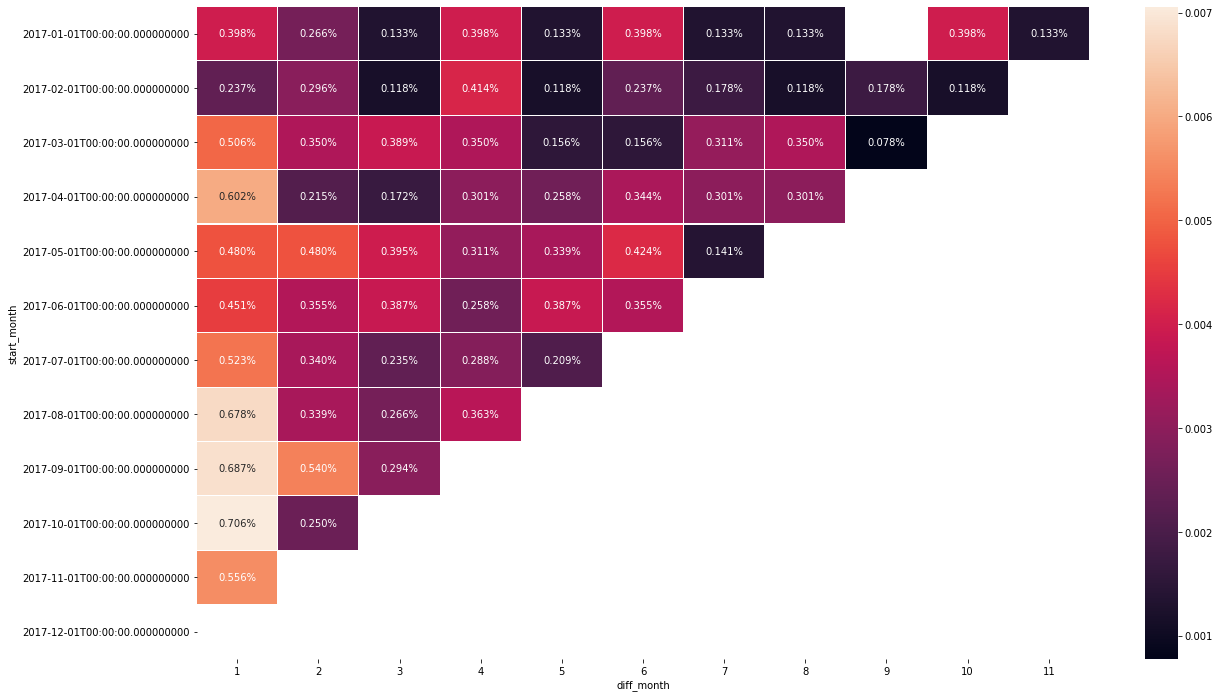

In [196]:
plt.figure(figsize=(20, 12))
ax = sns.heatmap(retention, annot=True, fmt=".3%", linewidth=.1)
#ax.set(title='Retention', ylabel='cohors', xlabel='date')
ax.tick_params(axis='y', rotation=0)
ax

In [39]:
max_cohort=df_cohort[2]/df_cohort[0] # первый месяц это колонка  - 0,второй - 1,третий месяц - 2, считаем retention  
max_cohort.idxmax() # находим когорту с самым высоким retention на 3й месяц 

Timestamp('2017-09-01 00:00:00')

### 6 Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию.
В кластеризации можешь выбрать следующие метрики: R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время.
Подробно опиши, как ты создавал кластеры. 

In [41]:
RFM_df=sales_df.query("order_status!=['unavailable','canceled','created']")
RFM_df.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05 00:00:00
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06 00:00:00
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13 00:00:00
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10 00:00:00
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15 00:00:00


In [42]:
RFM_df['order_purchase_timestamp'] = pd.to_datetime(RFM_df['order_purchase_timestamp']).dt.date #приводим колонку к типу даты

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [43]:
today=RFM_df['order_purchase_timestamp'].max()+timedelta(days=1) 
today
# создадим переменную ,которую примем за текущую дату(дата послдний покупки плюс один день) от которой будем считать давность покупки.

datetime.date(2018, 9, 4)

In [44]:
month=RFM_df.groupby('customer_unique_id').order_purchase_timestamp.max().reset_index()
month=month.rename(columns={'order_purchase_timestamp':'max_day'})
# создадим дф на примере прошлого задания,только с макс датой покупки(крайняя дата покупки для каждого пользователя)

In [45]:
RFM_df=RFM_df.merge(month,how='inner',on='customer_unique_id') # объеденим таблицы

In [46]:
RFM_df.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,max_day
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05 00:00:00,2017-05-16
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06 00:00:00,2018-01-12
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13 00:00:00,2018-05-19
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10 00:00:00,2018-03-13
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15 00:00:00,2018-07-29


In [47]:
RFM_df['diff_days'] =(today - RFM_df['max_day']) / np.timedelta64 ( 1 , 'D') 
# создадим колонку,с разницой между нашим крайним днем и крайним днем покупки 

In [48]:
RFM_df=RFM_df.merge(order_items,how='inner',on='order_id') # теперь объденим нашу таблицу с таблицей товаров в заказе
RFM_df.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,max_day,diff_days,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05 00:00:00,2017-05-16,476.0,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-05-22 15:22:12,124.99,21.88
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06 00:00:00,2018-01-12,235.0,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-01-18 20:58:32,289.00,46.48
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13 00:00:00,2018-05-19,108.0,1,bd07b66896d6f1494f5b86251848ced7,7c67e1448b00f6e969d365cea6b010ab,2018-06-05 16:19:10,139.94,17.79
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10 00:00:00,2018-03-13,175.0,1,a5647c44af977b148e0a3a4751a09e2e,7c67e1448b00f6e969d365cea6b010ab,2018-03-27 16:31:16,149.94,23.36
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15 00:00:00,2018-07-29,37.0,1,9391a573abe00141c56e38d84d7d5b3b,4a3ca9315b744ce9f8e9374361493884,2018-07-31 10:10:09,230.00,22.25


In [49]:
RFM=RFM_df.groupby('customer_unique_id',as_index=False).agg({'order_id':'count','price':'sum','diff_days':'min'}) 
# посчитаем количесвто заказов,сумму заказов,и давность последней покупки клиента

In [50]:
RFM.columns = ['customer_id', 'Frequency', 'Monetary', 'Recency'] #переименуем колонки

In [51]:
RFM.head()

,customer_id,Frequency,Monetary,Recency
0,0000366f3b9a7992bf8c76cfdf3221e2,1,129.90,117.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,18.90,120.0
2,0000f46a3911fa3c0805444483337064,1,69.00,543.0
3,0000f6ccb0745a6a4b88665a16c9f078,1,25.99,327.0
4,0004aac84e0df4da2b147fca70cf8255,1,180.00,294.0


In [52]:
# Теперь нам нужно каждый показатель разделить на 5 ступеней – от наименьшего к наибольшему. 

In [53]:
quintiles = RFM.quantile(q=[0.20, 0.40, 0.60, 0.80]).to_dict()
# используем метод квинтилей для каждого показателя

In [54]:
quintiles

{'Frequency': {0.2: 1.0, 0.4: 1.0, 0.6: 1.0, 0.8: 1.0},
 'Monetary': {0.2: 39.9, 0.4: 69.9, 0.6: 109.9, 0.8: 179.9},
 'Recency': {0.2: 99.0, 0.4: 183.0, 0.6: 274.0, 0.8: 389.0}}

In [55]:
def r_score(x):
    if x <= quintiles['Recency'][.2]:
        return 5
    elif x <= quintiles['Recency'][.4]:
        return 4
    elif x <= quintiles['Recency'][.6]:
        return 3
    elif x <= quintiles['Recency'][.8]:
        return 2
    else:
        return 1

def fm_score(x, y):
    if x <= quintiles[y][.2]:
        return 1
    elif x <= quintiles[y][.4]:
        return 2
    elif x <= quintiles[y][.6]:
        return 3
    elif x <= quintiles[y][.8]:
        return 4
    else:
        return 5    
# создаем функцию которая будет принимать показатель,и будет присваивать каждому значению ранг от 1 до 5.
# Учтем что у Recency чем меньше значение тем лучше,тем соотвественно выше ранг

In [56]:
RFM['R'] = RFM['Recency'].apply(lambda x: r_score(x))
RFM['F'] = RFM['Frequency'].apply(lambda x: fm_score(x, 'Frequency'))
RFM['M'] = RFM['Monetary'].apply(lambda x: fm_score(x, 'Monetary'))
# Применим функцию для каждого столбца со значениями

In [57]:
RFM.head()

,customer_id,Frequency,Monetary,Recency,R,F,M
0,0000366f3b9a7992bf8c76cfdf3221e2,1,129.90,117.0,4,1,4
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,18.90,120.0,4,1,1
2,0000f46a3911fa3c0805444483337064,1,69.00,543.0,1,1,2
3,0000f6ccb0745a6a4b88665a16c9f078,1,25.99,327.0,2,1,1
4,0004aac84e0df4da2b147fca70cf8255,1,180.00,294.0,2,1,5


In [58]:
RFM.F.value_counts()

1    83179
5    11804
Name: F, dtype: int64

In [59]:
RFM['RFM_segm']=RFM['R'].map(str) + RFM['F'].map(str) + RFM['M'].map(str)
# ЧТобы вывести окончательный столбец со значением,сплюсуем каждый ранг при этом нужно столбцы привести к строковому типу

In [60]:
RFM.head()

,customer_id,Frequency,Monetary,Recency,R,F,M,RFM_segm
0,0000366f3b9a7992bf8c76cfdf3221e2,1,129.90,117.0,4,1,4,414
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,18.90,120.0,4,1,1,411
2,0000f46a3911fa3c0805444483337064,1,69.00,543.0,1,1,2,112
3,0000f6ccb0745a6a4b88665a16c9f078,1,25.99,327.0,2,1,1,211
4,0004aac84e0df4da2b147fca70cf8255,1,180.00,294.0,2,1,5,215


In [61]:
#Сегментация . Разобьем наших клиентов на 6 групп
# 1 Lost -потерянные,заказ один и очень давно, при этом сумма заказа могла быть достаточно большой
# 2 Sleepy -спящие,заказывают не часто,требуют внимания,возможно делают заказы только во время промо 
# 3 New - новые,заказов мало,суммы могут быть как большие так и маленькие
# 4 Attention!!!-требующие внимание,заказывали часто,но давно,есть риск потерять клдиента
# 5 VIP - делают заказы постоянно, высокая сумма трат
# 6 perspective - покупают часто,заказов много,но суммы пока не очень большие

In [62]:
def gh(x):
    x=[int(i) for i in str(x)]
    if x[0]==1 and x[1]==1 and 1<=x[2]<5:
        return 'Lost'
    elif 1<=x[0]<=4 and 1<=x[1]<=3 and 1<=x[2]<=5:
        return 'Sleepy'
    elif x[0]==5 and 1<=x[1]<=3 and 1<=x[2]<=5:
        return 'New'
    elif 1<=x[0]<=2 and 4<=x[1]<=5 and 1<=x[2]<=5:
        return 'Attention!!!'
    elif 3<=x[0]<=5 and x[1]==5 and 4<=x[2]<=5:
        return 'VIP'
    elif 3<=x[0]<=5 and 4<=x[1]<=5 and 1<=x[2]<=3:
        return 'perspective'

In [63]:
RFM['rfm_clast']=RFM.RFM_segm.apply(gh)

In [64]:
RFM

,customer_id,Frequency,Monetary,Recency,R,F,M,RFM_segm,rfm_clast
0,0000366f3b9a7992bf8c76cfdf3221e2,1,129.90,117.0,4,1,4,414,Sleepy
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,18.90,120.0,4,1,1,411,Sleepy
2,0000f46a3911fa3c0805444483337064,1,69.00,543.0,1,1,2,112,Lost
3,0000f6ccb0745a6a4b88665a16c9f078,1,25.99,327.0,2,1,1,211,Sleepy
4,0004aac84e0df4da2b147fca70cf8255,1,180.00,294.0,2,1,5,215,Sleepy
...,...,...,...,...,...,...,...,...,...
94978,fffcf5a5ff07b0908bd4e2dbc735a684,2,1570.00,453.0,1,5,5,155,Attention!!!
94979,fffea47cd6d3cc0a88bd621562a9d061,1,64.89,268.0,3,1,2,312,Sleepy
94980,ffff371b4d645b6ecea244b27531430a,1,89.90,574.0,1,1,3,113,Lost
94981,ffff5962728ec6157033ef9805bacc48,1,115.00,125.0,4,1,4,414,Sleepy


In [65]:
RFM.rfm_clast.value_counts()

Sleepy          52625
New             16775
Lost            13779
Attention!!!     4667
VIP              4635
perspective      2502
Name: rfm_clast, dtype: int64

In [66]:
RFM.isna().sum()

customer_id    0
Frequency      0
Monetary       0
Recency        0
R              0
F              0
M              0
RFM_segm       0
rfm_clast      0
dtype: int64